# KAGGLE PROJECT: Malicious and Benign Websites
## Classification Models

***

#### Mireia Fernández Fernández (NIU 1562636)

TODO: add description!

In [1]:
# different imports for all the libraries used
import time 
import warnings
import numpy as np
import pandas as pd
%matplotlib inline 
from sklearn import preprocessing
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn import svm, tree, naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, KFold, LeaveOneOut, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.cluster import KMeans, SpectralClustering
from sklearn.metrics.cluster import completeness_score

sns.set(style="darkgrid")
warnings.filterwarnings("ignore")
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
# cell to clean, standardize and apply a pca to the data
dataset = pd.read_csv("dataset.csv")

dataset["CONTENT_LENGTH"] = dataset["CONTENT_LENGTH"].fillna(0)
dataset["DNS_QUERY_TIMES"] = dataset["DNS_QUERY_TIMES"].fillna(0)

dataset.drop(["URL", "WHOIS_STATEPRO"], axis=1, inplace=True)
dataset.drop([104, 290, 357, 383, 1067, 1306, 1394, 1400], inplace=True)

dataset.at[1360,'WHOIS_REGDATE'] = 'None' #none?
dataset.at[1001,'WHOIS_COUNTRY'] = 'UK'
dataset.at[1353,'WHOIS_COUNTRY'] = 'CY'
dataset.at[1411,'WHOIS_COUNTRY'] = 'CY'
dataset.at[30,'WHOIS_COUNTRY'] = 'SE'

for i in dataset.index[dataset['WHOIS_COUNTRY'] == 'GB'].tolist():
    dataset.at[i,'WHOIS_COUNTRY'] = 'UK'    
for i in dataset.index[dataset['WHOIS_COUNTRY'] == 'ru'].tolist():
    dataset.at[i,'WHOIS_COUNTRY'] = 'RU'

f_hour_day = lambda a, b: a + b/60 

def separate_attr(dataset, column, pos_year, pos_date, new_col_year, new_col_date):
    year = []
    hour = []
    for i in dataset[column]:
        if (i != 'None'):
            dyh = i.split(" ") 
            year.append(dyh[0].split("/")[2])
            hour.append(f_hour_day(*[int(j) for j in dyh[1].split(":")]))
        else:
            year.append(0) 
            hour.append(0) 

    dataset.insert(pos_year, new_col_year, year, True)
    dataset.insert(pos_date, new_col_date, hour, True)
    dataset.drop([column], axis=1, inplace=True)

separate_attr(dataset, "WHOIS_REGDATE", 6, 7, "WHOIS_REGD_YEAR", "WHOIS_REGD_HOUR")
separate_attr(dataset, "WHOIS_UPDATED_DATE", 8, 9, "WHOIS_REGUP_YEAR", "WHOIS_REGUP_HOUR")

dataset = pd.get_dummies(dataset, columns=["CHARSET","SERVER","WHOIS_COUNTRY"]) 

y = dataset["Type"]
dataset.drop(["Type"], axis=1, inplace=True)
X = dataset
sX = preprocessing.scale(X)

pca = PCA()
pca.fit(sX)
pca_data = pca.transform(sX)
labels = ['PC'+str(i) for i in range(1, 243)]
X = pd.DataFrame(pca_data[:,:242], columns=labels) # scaled pca dataset (exp var is 90%)

***
#### BASIC CLASSIFIERS

In [3]:
# first we define some functions in order to use them easilier later on

def fit_lr(X, y, part = 0.6):

    x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)
    logireg = LogisticRegression(C=2.0, fit_intercept=True, penalty='l2', tol=0.001) 
    logireg.fit(x_t, y_t)
    return logireg.score(x_v, y_v)


def fit_KNN(X, y, part = 0.6, n = 15):
    
    x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(x_t,y_t)
    y_pred=clf.predict(x_v)
    return metrics.accuracy_score(y_v, y_pred)


def fit_svm(X, y, part = 0.6, k = 'linear', C = 10.0, g = 0.9):
    x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)
    svc = svm.SVC(C=C, kernel=k, gamma=g, probability=True)   
    svc.fit(x_t, y_t)
    return svc.score(x_v, y_v)


def fit_decision_tree(X, y, part = 0.6):
    x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)
    dt = tree.DecisionTreeClassifier()
    dt.fit(x_t, y_t)
    y_pred=dt.predict(x_v)
    return metrics.accuracy_score(y_v, y_pred)


def fit_gnb(X, y, part = 0.6):
    x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)
    gnb = naive_bayes.GaussianNB()
    gnb.fit(x_t, y_t)
    return gnb.score(x_v, y_v)


def fit_rf(X, y, i = 50, part = 0.6):
    
    x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=part)
    clf = RandomForestClassifier(n_estimators=i)
    clf.fit(x_t,y_t)
    y_pred=clf.predict(x_v)
    return metrics.accuracy_score(y_v, y_pred)


In [4]:
# lets try a logistic regressor:

b = time.time()
result = fit_lr(X, y)
e = time.time()

print("LR accuracy:", result*100, "% | execution time:", e-b, "seconds")

LR accuracy: 93.09859154929578 % | execution time: 0.14013290405273438 seconds


In [5]:
# lets try some KNNs:

for neigh in [3, 5, 7, 10, 15]:
    b = time.time()
    result = fit_KNN(X, y, n = neigh)
    e = time.time()
    
    print(str(neigh)+"NN accuracy: "+str(100*result), "% | execution time:", e-b, "seconds")

3NN accuracy: 94.92957746478872 % | execution time: 0.2498922348022461 seconds
5NN accuracy: 95.63380281690141 % | execution time: 0.24534034729003906 seconds
7NN accuracy: 96.47887323943662 % | execution time: 0.284930944442749 seconds
10NN accuracy: 94.22535211267605 % | execution time: 0.28142619132995605 seconds
15NN accuracy: 94.64788732394366 % | execution time: 0.2882192134857178 seconds


In [6]:
# lets try a desicion tree:

b = time.time()
result = fit_decision_tree(X, y)
e = time.time()

print("LR accuracy:", result*100, "% | execution time:", e-b, "seconds")

LR accuracy: 93.52112676056338 % | execution time: 0.2373654842376709 seconds


In [7]:
# lets try a SVC() with every type of kernel we can use:

for kern in ['linear', 'poly', 'rbf', 'sigmoid']:
    b = time.time()
    result = fit_svm(X, y, k = kern)
    e = time.time()
    
    print(str(kern)+" SVC accuracy: "+str(100*result), "% | execution time:", e-b, "seconds")

linear SVC accuracy: 92.53521126760563 % | execution time: 0.7268612384796143 seconds
poly SVC accuracy: 88.30985915492958 % | execution time: 0.4444918632507324 seconds
rbf SVC accuracy: 95.77464788732394 % | execution time: 1.5661475658416748 seconds
sigmoid SVC accuracy: 74.08450704225352 % | execution time: 0.5338494777679443 seconds


In [8]:
# lets try a gausian naive bayes:

b = time.time()
result = fit_gnb(X, y)
e = time.time()

print("GNB accuracy:", result*100, "% | execution time:", e-b, "seconds")

GNB accuracy: 31.690140845070424 % | execution time: 0.20973467826843262 seconds


***
#### ENSEMBLE METHODS

In [9]:
# separate the dataset for the following classificators
x_t, x_v, y_t, y_v = train_test_split(X, y, train_size=0.6)

In [10]:
# lets try some random forests:

for trees in [10, 50, 100, 150, 300]:
    b = time.time()
    result = fit_rf(X, y, trees)
    e = time.time()
    
    print(str(trees)+"NN accuracy: "+str(100*result), "% | execution time:", e-b, "seconds")

10NN accuracy: 95.2112676056338 % | execution time: 0.05973005294799805 seconds
50NN accuracy: 95.49295774647887 % | execution time: 0.2701435089111328 seconds
100NN accuracy: 96.19718309859155 % | execution time: 0.5445160865783691 seconds
150NN accuracy: 95.91549295774648 % | execution time: 0.7501716613769531 seconds
300NN accuracy: 96.19718309859155 % | execution time: 1.5599157810211182 seconds


In [11]:
# bagging with a logistic regressor:

clf_lr = BaggingClassifier(base_estimator=LogisticRegression(C=2.0, fit_intercept=True, penalty='l2', tol=0.001), n_estimators=10, random_state=0).fit(x_t, y_t)
print("LR-Bagging accuracy: "+str(100*clf_lr.score(x_v, y_v)), "% | execution time:", e-b, "seconds")


LR-Bagging accuracy: 91.12676056338029 % | execution time: 1.5599157810211182 seconds


In [12]:
# bagging classifier with a knn with the number of neighbours that performs the best regressor:

clf_knn = BaggingClassifier(base_estimator=KNeighborsClassifier(n_neighbors = 10), n_estimators=10, random_state=0).fit(x_t, y_t)
print(str(10)+"NN-Bagging accuracy: "+str(100*clf_knn.score(x_v, y_v)), "% | execution time:", e-b, "seconds")


10NN-Bagging accuracy: 94.22535211267605 % | execution time: 1.5599157810211182 seconds


In [13]:
# bagging svc with the number of neighbours that performs the best regressor:

clf_svc = BaggingClassifier(base_estimator=svm.SVC(C=2.0, kernel='rbf', gamma=0.9, probability=True), n_estimators=10, random_state=0).fit(x_t, y_t)
print("SVC(rbf)-Bagging accuracy: "+str(100*clf_svc.score(x_v, y_v)), "% | execution time:", e-b, "seconds")


SVC(rbf)-Bagging accuracy: 96.05633802816902 % | execution time: 1.5599157810211182 seconds


In [14]:
# lets try some adaptive boosting classifiers:

for ests in [100, 500, 1000, 1500]:
    b = time.time()
    abc = AdaBoostClassifier(n_estimators=ests).fit(x_t, y_t)
    e = time.time()
    
    print(str(ests)+" AdaBoost accuracy: "+str(100*(abc.score(x_v,y_v))), "% | execution time:", e-b, "seconds")

100 AdaBoost accuracy: 95.35211267605634 % | execution time: 1.839972734451294 seconds
500 AdaBoost accuracy: 95.2112676056338 % | execution time: 9.209770202636719 seconds
1000 AdaBoost accuracy: 94.92957746478872 % | execution time: 18.196897745132446 seconds
1500 AdaBoost accuracy: 95.07042253521126 % | execution time: 27.186609983444214 seconds


In [15]:
# gradient boosting:

for ests in [100, 500, 1000, 1500]:
    b = time.time()
    clf = GradientBoostingClassifier(n_estimators=ests, learning_rate=1.0, max_depth=3, random_state=0).fit(x_t, y_t)
    e = time.time()
    
    print(str(ests)+"-GB accuracy: "+str(100*clf.score(x_v, y_v)), "% | execution time:", e-b, "seconds")

100-GB accuracy: 93.52112676056338 % | execution time: 0.8102152347564697 seconds
500-GB accuracy: 93.52112676056338 % | execution time: 1.7807321548461914 seconds
1000-GB accuracy: 93.52112676056338 % | execution time: 3.1501119136810303 seconds
1500-GB accuracy: 93.52112676056338 % | execution time: 4.540017604827881 seconds


***
#### CLUSTERING

In [16]:
# kmeans method:

for clus in [5, 6, 7, 8, 9, 10, 15, 20]:
    b = time.time()
    kmns = KMeans(n_clusters= clus)
    y_pred = kmns.fit_predict(X)
    e = time.time()
    
    print(str(clus)+"-Means accuracy: "+str(100*completeness_score(y, y_pred)), "% | execution time:", e-b, "seconds")


5-Means accuracy: 7.798896780573888 % | execution time: 0.3704054355621338 seconds
6-Means accuracy: 3.4535723724890763 % | execution time: 0.3201179504394531 seconds
7-Means accuracy: 3.764128753241332 % | execution time: 0.30019092559814453 seconds
8-Means accuracy: 0.24047277658601615 % | execution time: 0.3646275997161865 seconds
9-Means accuracy: 2.859148940634244 % | execution time: 0.3098180294036865 seconds
10-Means accuracy: 4.902995295915304 % | execution time: 0.30161166191101074 seconds
15-Means accuracy: 4.141790591451778 % | execution time: 0.41870737075805664 seconds
20-Means accuracy: 8.169690368755221 % | execution time: 0.4747447967529297 seconds


In [17]:
# spectral clustering method:

for clus in [8, 10, 12]:
    for assign in ['kmeans', 'discretize']:
        b = time.time()
        y_pred = SpectralClustering(n_clusters=clus, assign_labels=assign).fit_predict(X)
        e = time.time()
    
        print(assign, str(clus)+"-Spectral accuracy: "+str(100*completeness_score(y, y_pred)), "% | execution time:", e-b, "seconds")


kmeans 8-Spectral accuracy: 1.5324178227940044 % | execution time: 317.76536417007446 seconds
discretize 8-Spectral accuracy: 1.0845964050500665 % | execution time: 333.05747413635254 seconds
kmeans 10-Spectral accuracy: 1.5324178227940044 % | execution time: 249.3796989917755 seconds
discretize 10-Spectral accuracy: 0.7043373257441014 % | execution time: 248.67166924476624 seconds
kmeans 12-Spectral accuracy: 1.5324178227940044 % | execution time: 295.27912068367004 seconds
discretize 12-Spectral accuracy: 0.7431569496539053 % | execution time: 300.7488317489624 seconds


***
#### **CROSS VALIDATION**

Here we will take the best three models (KNN, SVM, Random Forest) with their best parameters found manually to make sure that they perform well enough and does not suffer form overfitting.

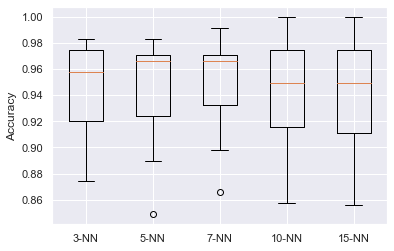

In [18]:
# First we look at different types of KNN:
scores_knn = []
for neigh in [3, 5, 7, 10, 15]:
    model = KNeighborsClassifier(n_neighbors=neigh)
    scores_knn.append(cross_val_score(model, X, y, cv=15))
    
plt.boxplot(scores_knn)   
ax = plt.gca()
ax.set_xticklabels(['3-NN', '5-NN', '7-NN', '10-NN', '15-NN'])
plt.ylabel('Accuracy')
plt.show()

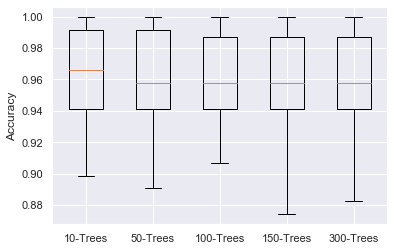

In [19]:
# then we look at some random forest classifiers with different number of trees:
scores_rfs = []
for trees in [10, 50, 100, 150, 300]:
    model = RandomForestClassifier(n_estimators=trees)
    scores_rfs.append(cross_val_score(model, X, y, cv=15))
    
plt.boxplot(scores_rfs)   
ax = plt.gca()
ax.set_xticklabels(['10-Trees', '50-Trees', '100-Trees', '150-Trees', '300-Trees'])
plt.ylabel('Accuracy')
plt.show()

In [20]:
# get the score for the svm with a rbf kernel:

model = svm.SVC(C=2.0, kernel='rbf', gamma=0.9, probability=True)
score_svm = cross_val_score(model, X, y, cv=15)

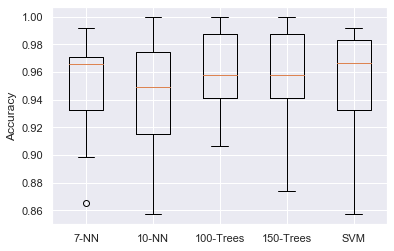

In [21]:
# boxplot of the best five models:

plt.boxplot([scores_knn[2], scores_knn[3], scores_rfs[2], scores_rfs[3], score_svm])   
ax = plt.gca()
ax.set_xticklabels(['7-NN', '10-NN', '100-Trees', '150-Trees', 'SVM'])
plt.ylabel('Accuracy')
plt.show()

***
#### **HYPERPARAMETER SEARCH**

For each model selected (KNN, Random Forest, SVM):

In [22]:
# again, separate the data to perform the search
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8)

In [23]:
#search for the svm model

cs = np.logspace(-2, 6, 40)
tuned_parameters = [{"C": cs}]
scores = ["precision", "recall"]
meanss = []
stdss = []
bests = []

for score in scores:
    print("Tuning hyper-parameters for %s\n" % score)

    clf = GridSearchCV(svm.SVC(kernel = 'rbf'), tuned_parameters, scoring="%s_macro" % score)
    clf.fit(X_train, y_train)

    print("Best parameter found:", clf.best_params_, "\n")
    bests.append(clf.best_params_['C'])

    means = clf.cv_results_["mean_test_score"]
    meanss.append(means)
    
    stds = clf.cv_results_["std_test_score"]
    stdss.append(stds)

Tuning hyper-parameters for precision

Best parameter found: {'C': 19.144819761699576} 

Tuning hyper-parameters for recall

Best parameter found: {'C': 49.238826317067364} 



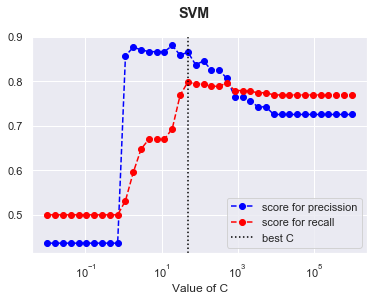

In [24]:
# graph to visualize the hyperparameter search 

fig = plt.figure()

plt.suptitle("SVM", fontsize = 'x-large', fontweight = 'bold')
plt.plot(cs, meanss[0], "o--", label="score for precission", color="blue")
plt.plot(cs, meanss[1], "o--", label="score for recall", color="red")
plt.xscale("log")
plt.axis('tight')
plt.xlabel('Value of C')
plt.axvline(x=bests[1], color='black', label='best C', ls = ":")

plt.legend()
plt.show()

Minimum error: 0.05144467935165609 at K = 2 with accuracy: 94.85553206483439


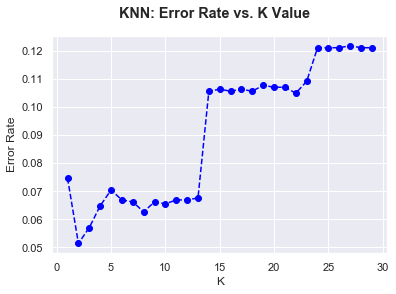

In [25]:
#search for the knn model

error_rate = []
acc_score = []
for i in range(1,30):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    acc_score.append(metrics.accuracy_score(y_test, pred_i))

plt.figure()
plt.suptitle("KNN: Error Rate vs. K Value", fontsize = 'x-large', fontweight = 'bold')
plt.plot(range(1,30), error_rate, 'o--', color='blue')
plt.xlabel('K')
plt.ylabel('Error Rate')

print("Minimum error:", min(error_rate),"at K =", error_rate.index(min(error_rate))+1, "with accuracy:", acc_score[error_rate.index(min(error_rate))]*100)

Minimum error: 0.040169133192389 at Trees = 111 with accuracy: 95.9830866807611


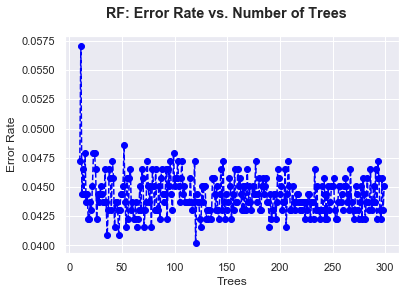

In [27]:
#search for the random forest model

error_rate = []
acc_score = []
for i in range(10,300):
    rf = RandomForestClassifier(n_estimators=i)
    rf.fit(X_train,y_train)
    pred_i = rf.predict(X_test)
    error_rate.append(np.mean(pred_i != y_test))
    acc_score.append(metrics.accuracy_score(y_test, pred_i))
    
plt.figure()
plt.suptitle("RF: Error Rate vs. Number of Trees", fontsize = 'x-large', fontweight = 'bold')
plt.plot(range(10,300), error_rate, 'o--', color='blue')
plt.xlabel('Trees')
plt.ylabel('Error Rate')

print("Minimum error:", min(error_rate),"at Trees =", error_rate.index(min(error_rate))+1, "with accuracy:", acc_score[error_rate.index(min(error_rate))]*100)